In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Step 1: Load the Raw Dataset
raw_dataset = pd.read_csv("NYPD_Arrest_Data__Year_to_Date_.csv")


In [2]:
# Step 2: Data Overview
print("Raw Dataset Shape:", raw_dataset.shape)
print("Columns:", raw_dataset.columns)
print("Missing Values:\n", raw_dataset.isnull().sum())

Raw Dataset Shape: (128778, 19)
Columns: Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column'],
      dtype='object')
Missing Values:
 ARREST_KEY                    0
ARREST_DATE                   0
PD_CD                         4
PD_DESC                       0
KY_CD                        15
OFNS_DESC                     0
LAW_CODE                      0
LAW_CAT_CD                  770
ARREST_BORO                   0
ARREST_PRECINCT               0
JURISDICTION_CODE             0
AGE_GROUP                     0
PERP_SEX                      0
PERP_RACE                     0
X_COORD_CD                    0
Y_COORD_CD                    0
Latitude                      0
Longitude                     0
New Georeferenced Column      0
dtype: int64

In [3]:
# Step 3: Create a Copy for Cleaning
clean_dataset = raw_dataset.copy()

In [4]:
# Step 4: Correct Missing Values
if 'pd_cd' in clean_dataset.columns:
    clean_dataset['pd_cd'].fillna(-1, inplace=True)
if 'ky_cd' in clean_dataset.columns:
    clean_dataset['ky_cd'].fillna(-1, inplace=True)
if 'law_cat_cd' in clean_dataset.columns:
    clean_dataset['law_cat_cd'].fillna('Unknown', inplace=True)

In [6]:
# Check remaining missing values in key columns
print("Remaining Missing Values:\n", clean_dataset[['PD_CD', 'KY_CD', 'LAW_CAT_CD']].isnull().sum())

Remaining Missing Values:
 PD_CD           4
KY_CD          15
LAW_CAT_CD    770
dtype: int64


In [7]:
# Step 5: Handle Duplicate Rows
duplicates = clean_dataset.duplicated()
print("Number of Duplicate Rows:", duplicates.sum())
clean_dataset = clean_dataset.drop_duplicates()

Number of Duplicate Rows: 0


In [9]:
# Step 6: Convert `arrest_date` to Datetime and Format
clean_dataset['ARREST_DATE'] = pd.to_datetime(clean_dataset['ARREST_DATE'], errors='coerce')
clean_dataset.dropna(subset=['ARREST_DATE'], inplace=True)
clean_dataset['ARREST_DATE'] = clean_dataset['ARREST_DATE'].dt.strftime('%m/%d/%Y')


In [11]:
# Confirm the date range after formatting
print("Date Range:", clean_dataset['ARREST_DATE'].min(), clean_dataset['ARREST_DATE'].max())

Date Range: 01/01/2024 06/30/2024


In [12]:
# Step 7: Map Singular Values to Descriptions
replacements = {
    'ARREST_BORO': {
        'M': 'Manhattan',
        'K': 'Brooklyn',
        'Q': 'Queens',
        'B': 'Bronx',
        'S': 'Staten Island'
    },
    'PERP_SEX': {
        'M': 'Male',
        'F': 'Female',
        'UNKNOWN': 'Unknown'
    },
    'LAW_CAT_CD': {
        'F': 'Felony',
        'M': 'Misdemeanor',
        'V': 'Violation',
        '9': 'Unknown',
        'I': 'Infraction',
        '(null)': 'Unknown'
    }
}

# Apply replacements
for column, mapping in replacements.items():
    if column in clean_dataset.columns:
        clean_dataset[column] = clean_dataset[column].replace(mapping)

# Verify replacements
for column in replacements.keys():
    if column in clean_dataset.columns:
        print(f"Unique values in {column} after replacement:")
        print(clean_dataset[column].unique())

Unique values in ARREST_BORO after replacement:
['Brooklyn' 'Queens' 'Staten Island' 'Bronx' 'Manhattan']
Unique values in PERP_SEX after replacement:
['Male' 'Female']
Unique values in LAW_CAT_CD after replacement:
['Felony' 'Misdemeanor' 'Violation' nan 'Unknown' 'Infraction']


In [14]:
# Step 8: Filter Geographical Data
clean_dataset = clean_dataset[
    (clean_dataset['Latitude'].between(40.4774, 40.9176)) & 
    (clean_dataset['Longitude'].between(-74.2591, -73.7004))
]

In [15]:
# Final Cleaned Dataset Overview
print("Cleaned Dataset Shape:", clean_dataset.shape)
print(clean_dataset.head())

Cleaned Dataset Shape: (128776, 19)
   ARREST_KEY ARREST_DATE  PD_CD                   PD_DESC  KY_CD  \
0   279884335  01/03/2024  153.0                    RAPE 3  104.0   
1   279876234  01/03/2024  105.0         STRANGULATION 1ST  106.0   
2   279939192  01/04/2024  109.0  ASSAULT 2,1,UNCLASSIFIED  106.0   
3   280561026  01/15/2024  203.0      TRESPASS 3, CRIMINAL  352.0   
4   280084387  01/07/2024  223.0  BURGLARY,RESIDENCE,NIGHT  107.0   

           OFNS_DESC    LAW_CODE   LAW_CAT_CD    ARREST_BORO  ARREST_PRECINCT  \
0               RAPE  PL 1302503       Felony       Brooklyn               77   
1     FELONY ASSAULT  PL 1211200       Felony         Queens              101   
2     FELONY ASSAULT  PL 1201001       Felony       Brooklyn               83   
3  CRIMINAL TRESPASS  PL 140100A  Misdemeanor  Staten Island              121   
4           BURGLARY  PL 1403002       Felony         Queens              107   

   JURISDICTION_CODE AGE_GROUP PERP_SEX PERP_RACE  X_COORD_CD 

In [17]:
print(f"Clean Dataset Shape: {clean_dataset.shape}")
print(clean_dataset.head())


Clean Dataset Shape: (128776, 23)
   ARREST_KEY ARREST_DATE  PD_CD                   PD_DESC  KY_CD  \
0   279884335  01/03/2024  153.0                    RAPE 3  104.0   
1   279876234  01/03/2024  105.0         STRANGULATION 1ST  106.0   
2   279939192  01/04/2024  109.0  ASSAULT 2,1,UNCLASSIFIED  106.0   
3   280561026  01/15/2024  203.0      TRESPASS 3, CRIMINAL  352.0   
4   280084387  01/07/2024  223.0  BURGLARY,RESIDENCE,NIGHT  107.0   

           OFNS_DESC    LAW_CODE   LAW_CAT_CD    ARREST_BORO  ARREST_PRECINCT  \
0               RAPE  PL 1302503       Felony       Brooklyn               77   
1     FELONY ASSAULT  PL 1211200       Felony         Queens              101   
2     FELONY ASSAULT  PL 1201001       Felony       Brooklyn               83   
3  CRIMINAL TRESPASS  PL 140100A  Misdemeanor  Staten Island              121   
4           BURGLARY  PL 1403002       Felony         Queens              107   

   ...  PERP_RACE X_COORD_CD Y_COORD_CD   Latitude  Longitude  \

In [18]:
# Step 1: Add Date-Based Features
clean_dataset['arrest_year'] = pd.to_datetime(clean_dataset['ARREST_DATE']).dt.year
clean_dataset['arrest_month'] = pd.to_datetime(clean_dataset['ARREST_DATE']).dt.month
clean_dataset['day_of_week'] = pd.to_datetime(clean_dataset['ARREST_DATE']).dt.day_name()
clean_dataset['is_weekend'] = clean_dataset['day_of_week'].isin(['Saturday', 'Sunday'])

In [20]:
# Displaying the outputs for Step 1
print(clean_dataset[['ARREST_DATE', 'arrest_year', 'arrest_month', 'day_of_week', 'is_weekend']])

       ARREST_DATE  arrest_year  arrest_month day_of_week  is_weekend
0       01/03/2024         2024             1   Wednesday       False
1       01/03/2024         2024             1   Wednesday       False
2       01/04/2024         2024             1    Thursday       False
3       01/15/2024         2024             1      Monday       False
4       01/07/2024         2024             1      Sunday        True
...            ...          ...           ...         ...         ...
128773  06/14/2024         2024             6      Friday       False
128774  06/19/2024         2024             6   Wednesday       False
128775  06/20/2024         2024             6    Thursday       False
128776  06/11/2024         2024             6     Tuesday       False
128777  06/15/2024         2024             6    Saturday        True

[128776 rows x 5 columns]


In [23]:
# Step 2: Create Severity Index
severity_mapping = {'Felony': 3, 'Misdemeanor': 2, 'Violation': 1}
clean_dataset['severity_index'] = clean_dataset['LAW_CAT_CD'].map(severity_mapping)
print("\nSeverity Index Feature:")
print(clean_dataset[['LAW_CAT_CD', 'severity_index']].head())



Severity Index Feature:
    LAW_CAT_CD  severity_index
0       Felony             3.0
1       Felony             3.0
2       Felony             3.0
3  Misdemeanor             2.0
4       Felony             3.0


In [26]:
# Step 3: Add Location-Based Features
clean_dataset['location_zone'] = clean_dataset.apply(
    lambda row: 'North NYC' if row['Latitude'] > 40.75 else 'South NYC', axis=1
)
clean_dataset['boro_severity'] = clean_dataset['ARREST_BORO'] + '_' + clean_dataset['LAW_CAT_CD']

print("\nLocation-Based Features:")
print(clean_dataset[['Latitude', 'Longitude', 'location_zone', 'boro_severity']].head())


Location-Based Features:
    Latitude  Longitude location_zone              boro_severity
0  40.674496 -73.930571     South NYC            Brooklyn_Felony
1  40.602740 -73.750081     South NYC              Queens_Felony
2  40.698323 -73.917495     South NYC            Brooklyn_Felony
3  40.623238 -74.149217     South NYC  Staten Island_Misdemeanor
4  40.734681 -73.810626     South NYC              Queens_Felony


ValueError: Unknown format code 'd' for object of type 'float'

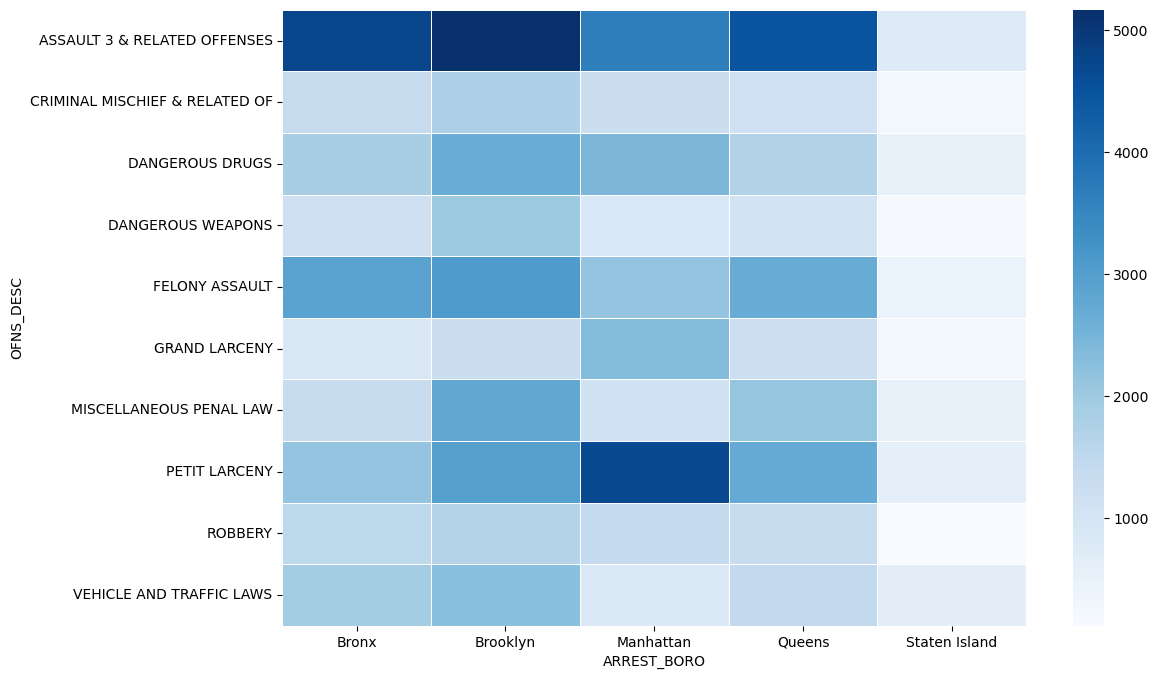

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Identify Top 10 Offenses
top_offenses = clean_dataset['OFNS_DESC'].value_counts().nlargest(10).index

# Step 2: Filter Dataset for Top Offenses
filtered_dataset = clean_dataset[clean_dataset['OFNS_DESC'].isin(top_offenses)]

# Step 3: Aggregate Data by Borough and Offense
heatmap_data = filtered_dataset.groupby(['ARREST_BORO', 'OFNS_DESC']).size().reset_index(name='count')

# Step 4: Create a Pivot Table for Heatmap
heatmap = pd.pivot_table(heatmap_data, values='count', index='OFNS_DESC', columns='ARREST_BORO', fill_value=0)

# Step 5: Plot the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap, cmap='Blues', annot=True, fmt='d', linewidths=.5)

# Step 6: Customize Plot Titles and Labels
plt.title('Heatmap of Top 10 Offenses by Borough', fontsize=16)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Offense Description', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Step 7: Show the Heatmap
plt.show()


<Figure size 1200x800 with 0 Axes>

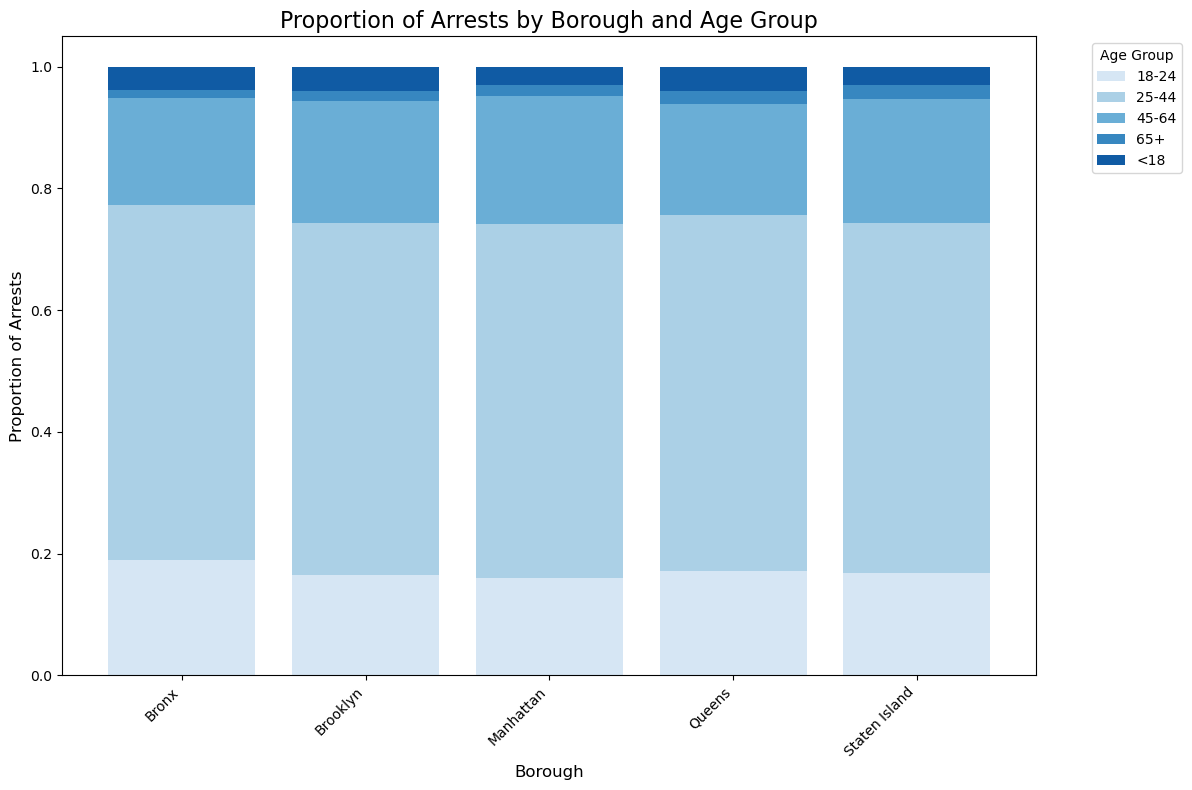

In [31]:
# Proportion of Arrests by Borough and Age Group
borough_age = clean_dataset.groupby(['ARREST_BORO', 'AGE_GROUP']).size().reset_index(name='count')
borough_age['proportion'] = borough_age.groupby('ARREST_BORO')['count'].transform(lambda x: x / x.sum())
borough_age_pivot = borough_age.pivot_table(index='ARREST_BORO', columns='AGE_GROUP', values='proportion', aggfunc='sum')

# Plot the Stacked Bar Chart with Uniform Color Palette
plt.figure(figsize=(12, 8))
custom_colors = sns.color_palette('Blues', n_colors=len(borough_age_pivot.columns))
borough_age_pivot.plot(kind='bar', stacked=True, figsize=(12, 8), color=custom_colors, width=0.8)

plt.title('Proportion of Arrests by Borough and Age Group', fontsize=16)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Proportion of Arrests', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

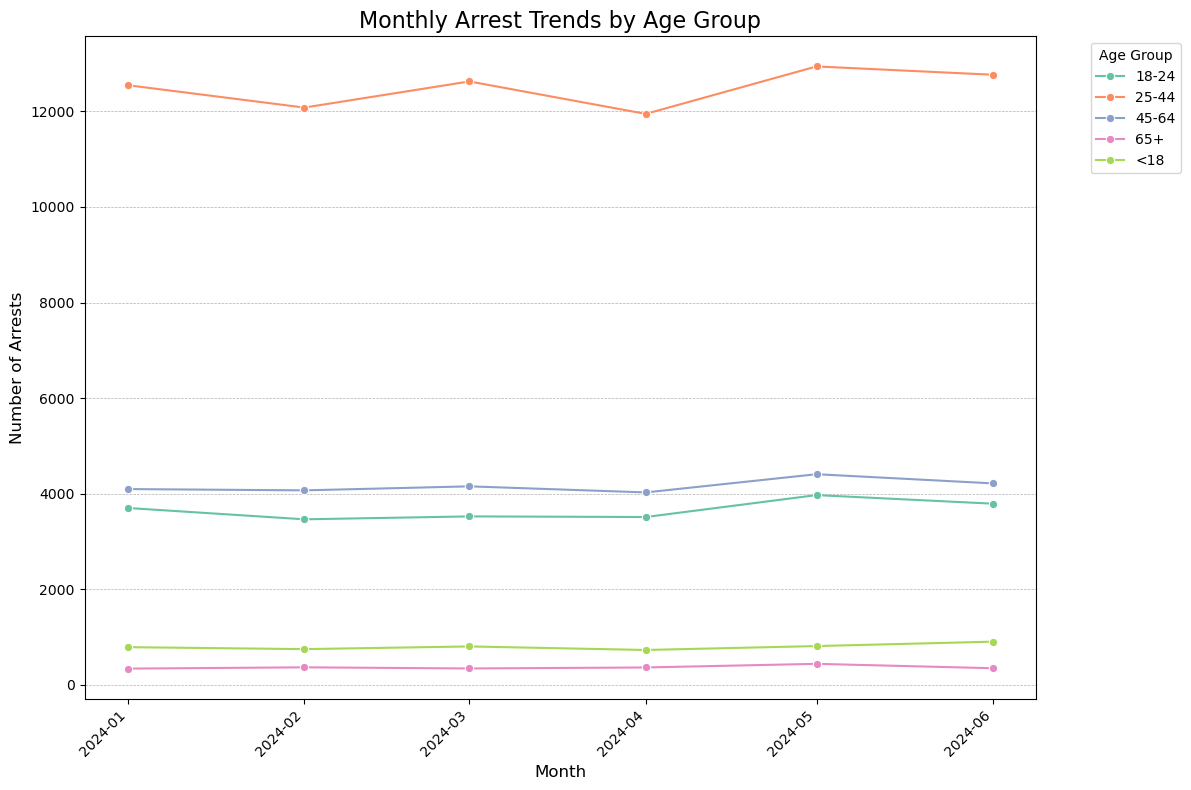

In [36]:
# Convert 'ARREST_DATE' to datetime format if not already
clean_dataset['ARREST_DATE'] = pd.to_datetime(clean_dataset['ARREST_DATE'], errors='coerce')

# Monthly Arrest Trends by Age Group
monthly_trends = (
    clean_dataset.groupby([clean_dataset['ARREST_DATE'].dt.to_period('M'), 'AGE_GROUP'])
    .size()
    .reset_index(name='count')
)

# Convert 'ARREST_DATE' to a proper timestamp for plotting
monthly_trends['month'] = monthly_trends['ARREST_DATE'].dt.to_timestamp()

# Ensure 'AGE_GROUP' is a categorical variable for better plotting
monthly_trends['AGE_GROUP'] = monthly_trends['AGE_GROUP'].astype('category')

# Plot the line chart
plt.figure(figsize=(12, 8))
sns.lineplot(data=monthly_trends, x='month', y='count', hue='AGE_GROUP', palette='Set2', marker='o')

# Add title and labels
plt.title('Monthly Arrest Trends by Age Group', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Arrests', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


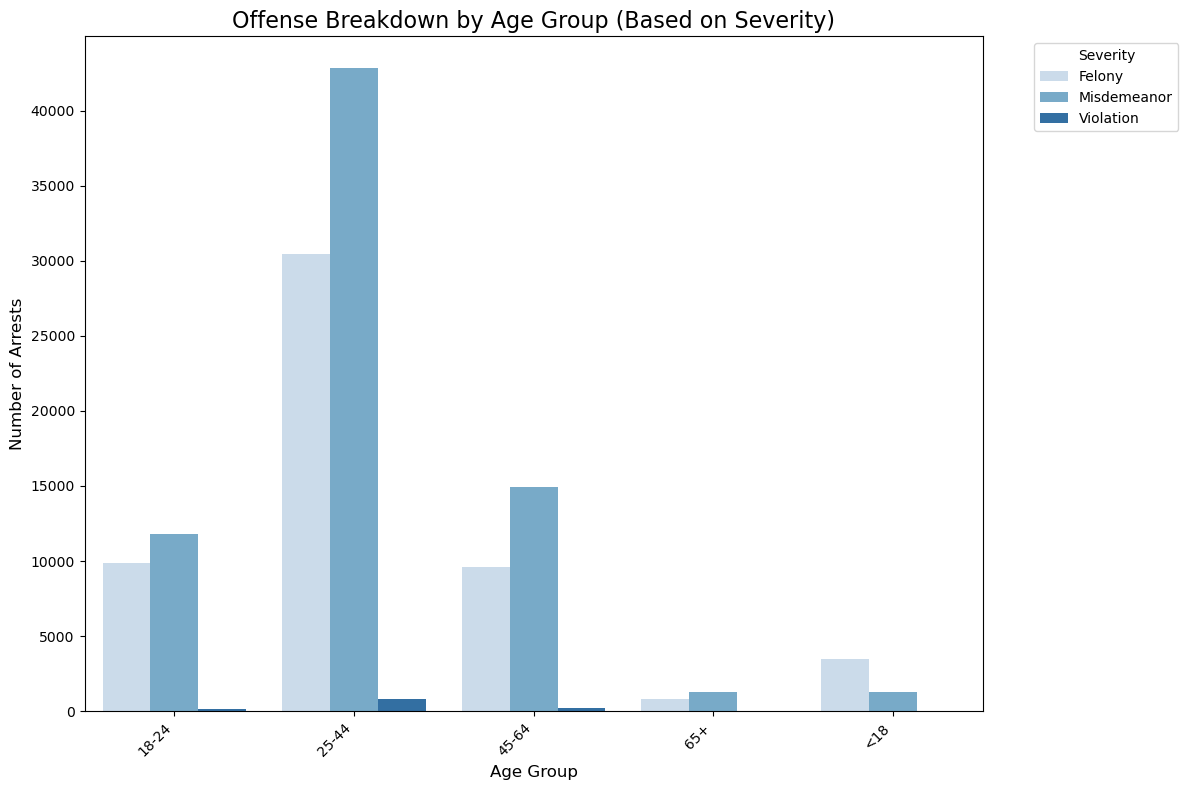

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map severity levels to numeric values
severity_mapping = {'Felony': 3, 'Misdemeanor': 2, 'Violation': 1}
clean_dataset['SEVERITY_INDEX'] = clean_dataset['LAW_CAT_CD'].map(severity_mapping)

# Group by AGE_GROUP and SEVERITY_INDEX
offense_age = (
    clean_dataset.groupby(['AGE_GROUP', 'SEVERITY_INDEX'])
    .size()
    .reset_index(name='COUNT')
    .sort_values(by='SEVERITY_INDEX', ascending=False)
)

# Map numeric severity levels back to descriptive labels
severity_labels = {3: 'Felony', 2: 'Misdemeanor', 1: 'Violation'}
offense_age['SEVERITY_CATEGORY'] = offense_age['SEVERITY_INDEX'].map(severity_labels)

# Custom color palette
custom_blues = sns.color_palette('Blues', n_colors=3)

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=offense_age, x='AGE_GROUP', y='COUNT', hue='SEVERITY_CATEGORY', palette=custom_blues)

# Customize plot titles and labels
plt.title('Offense Breakdown by Age Group (Based on Severity)', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Arrests', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# The Random Forest model achieved an accuracy of 62.8%, indicating that it correctly predicts 
# the offense severity in approximately 63% of the cases. The classification report shows that 
# the model performs well for the majority class (e.g., class `2`, likely the most frequent severity 
# level), as evidenced by higher precision and recall values for this class compared to others. 
# However, performance is limited for underrepresented classes (e.g., class `1`), as indicated by 
# low precision, recall, and F1-scores, likely due to class imbalance in the dataset.

# The feature importance analysis highlights that latitude and longitude are the most influential 
# predictors, followed by age group and perpetrator race. Interestingly, features like ARREST_BORO 
# and IS_WEEKEND have relatively low importance, suggesting that geographical data and demographic 
# attributes play a larger role in determining offense severity.


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Step 1: Data Preparation
# Define features and target variable
features = ['AGE_GROUP', 'PERP_RACE', 'PERP_SEX', 'ARREST_BORO', 'is_weekend', 'Latitude', 'Longitude']
target = 'LAW_CAT_CD'

# Ensure all required columns exist and drop rows with missing values in features or target
clean_dataset = clean_dataset.dropna(subset=features + [target])

# Encode categorical variables
label_encoders = {}
for col in features:
    if clean_dataset[col].dtype == 'object' or clean_dataset[col].dtype.name == 'category':
        le = LabelEncoder()
        clean_dataset[col] = le.fit_transform(clean_dataset[col])
        label_encoders[col] = le

# Separate features and target
X = clean_dataset[features]
y = clean_dataset[target]

# Encode target variable
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Model Selection
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 3: Model Training
model.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred = model.predict(X_test)

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 5: Feature Importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importances)


/tmp/ipykernel_707/376868452.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset[col] = le.fit_transform(clean_dataset[col])
/tmp/ipykernel_707/376868452.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset[col] = le.fit_transform(clean_dataset[col])
/tmp/ipykernel_707/376868452.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

Accuracy: 0.6283787302744649

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.55      0.57     16265
           1       0.00      0.00      0.00        33
           2       0.67      0.69      0.68     21623
           3       0.19      0.10      0.13       110
           4       0.45      0.26      0.33       371

    accuracy                           0.63     38402
   macro avg       0.38      0.32      0.34     38402
weighted avg       0.62      0.63      0.63     38402


Confusion Matrix:
 [[ 9017     0  7191    22    35]
 [    9     0    24     0     0]
 [ 6507     2 15005    25    84]
 [   29     0    70    11     0]
 [   47     0   225     1    98]]

Feature Importances:
        Feature  Importance
5     Latitude    0.445732
6    Longitude    0.443651
0    AGE_GROUP    0.052245
1    PERP_RACE    0.035715
3  ARREST_BORO    0.008882
2     PERP_SEX    0.006966
4   is_weekend    0.006810


In [ ]:
#2 Anamoly Detection:
# This visualization shows the results of anomaly detection applied to arrest data 
# using features like latitude, longitude, and severity index. The plot highlights 
# anomalous arrests (marked in blue) as distinct from normal patterns (marked in red).

# The anomalies may represent unusual arrests based on location or other factors,
# such as arrests occurring in areas where severe crimes are rare or infrequent activity is observed.

# The use of an anomaly detection model (e.g., Isolation Forest) helps identify these outliers,
# which can provide actionable insights for law enforcement, such as focusing on specific
# locations or understanding rare events for improved resource allocation.


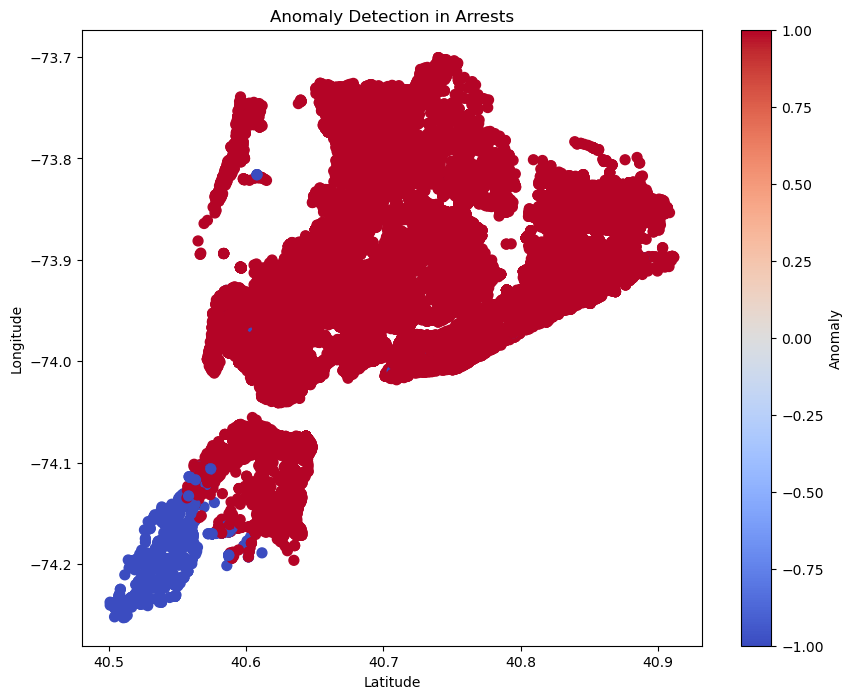

In [40]:
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection
anomaly_features = ['Latitude', 'Longitude', 'SEVERITY_INDEX']
X = clean_dataset[anomaly_features].dropna()

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
X['Anomaly'] = iso_forest.fit_predict(X)

# Visualize Anomalies
plt.figure(figsize=(10, 8))
plt.scatter(X['Latitude'], X['Longitude'], c=X['Anomaly'], cmap='coolwarm', s=50)
plt.title("Anomaly Detection in Arrests")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.colorbar(label="Anomaly")
plt.show()


In [42]:
pip install prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 86.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#3 Forecast monthly Arrest Trends:
# This visualization presents a forecast of monthly arrest trends using the Prophet model. 
# The blue line represents the predicted number of arrests over time, while the shaded 
# area indicates the uncertainty interval around the forecast. The model has captured 
# the general upward trend in arrests, suggesting an increase in future months.

# This forecast is based on historical data and can be used for planning purposes, 
# such as allocating law enforcement resources. The uncertainty interval provides a 
# range within which the actual values are expected to fall, offering a measure of 
# confidence in the predictions.


22:41:55 - cmdstanpy - INFO - Chain [1] start processing
22:41:55 - cmdstanpy - INFO - Chain [1] done processing


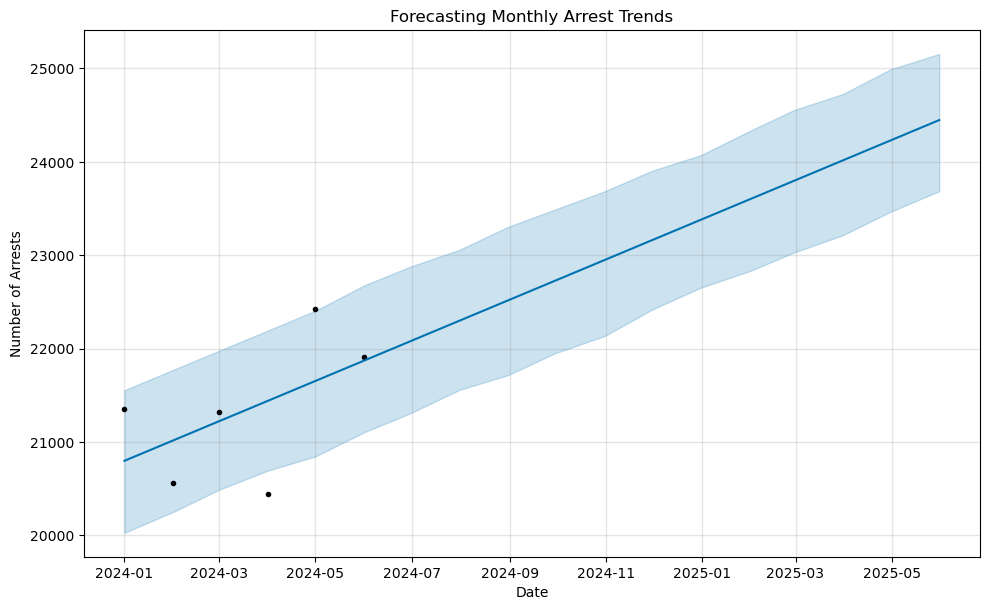

In [45]:
from prophet import Prophet

# Prepare data for forecasting
time_series = clean_dataset.groupby(clean_dataset['ARREST_DATE'].dt.to_period('M')).size().reset_index(name='count')
time_series['ARREST_DATE'] = time_series['ARREST_DATE'].dt.to_timestamp()
time_series = time_series.rename(columns={'ARREST_DATE': 'ds', 'count': 'y'})

# Train the Prophet model
model = Prophet()
model.fit(time_series)

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast)
plt.title("Forecasting Monthly Arrest Trends")
plt.xlabel("Date")
plt.ylabel("Number of Arrests")
plt.show()
